# Convolution Neural Network
In this notebook, we aim to explore what Convolution Neural Networks(CNN) are, and apply them onto the _MNIST_ dataset. By doing so, we hope to grasp the foundational concepts and apply the learning points onto **Binar.ai**.

## Convolution Neural Network
Convolutional Neural Networks (CNNs) are artificial neural networks used for image classification, object recognition, and computer vision tasks. Unlike typical neural networks, CNNs process variable-sized input data, such as images. There are two main components in a CNN:
1. Convolution Layers<br>
Convolution layers apply filters to input data. These filters recognize specific input features, such as edges, shapes, or textures. The output of each convolution layer is passed through a non-linear activation function(e.g. ReLU), which introduces _non-linearity*_ into the network.
2. Pooling Layers<br>
Pooling layers are used to downsample the output of convolutional layers. This reduces the spatial size of input, _making it more manageable for subsequent layers to process**_.


Here are the steps involved in the process of a Convolutional Neural Network (CNN) analyzing an image:
1. The input image is passed through multiple convolutional layers.
Each convolutional layer has its own set of filters.
2. The output of each convolutional layer is passed through an activation function.
3. The output of each convolutional layer is passed through a pooling layer.
4. The output is then fed into the next convolutional layer.
5. The final output of the network is passed through a fully-connected layer.
6. The final output is passed through a softmax activation function.
7. This produces a probability distribution over the possible classes the image belongs to.

_* - Non-linearity allows for more complex relationships between inputs and output to be modeled. This ensures that the output from a neuron is not linear combination of its inputs, allowing the NN to learn more complex features and relationships in input data._<br>
_** - Reducing spatial size of input data reduces the number of parameters that subsequent layers have to proess. Doing so reduces the computational complexity of the network, additionally also extracts the most important features from the input data, which can improve the performance of the network by reducing impact of noise and irrelevant details._<br><br>
Check out this [link](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) to get a better understanding(with pictures!) of CNNs, or [here](https://www.youtube.com/watch?v=JB8T_zN7ZC0&t=905s&ab_channel=BrandonRohrer) to understand CNN in depth.

## Implementation
Following the brief explaination on what a CNN is, let's attempt to implement a handwritten digit detection algorithm using TensorFlow.<br><br>
First let's import the relevant libraries:

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

Next, we load the _MNIST_ dataset and reshape the arrays to have 1 color channel since we are dealing with greyscale images

*** MNIST Train ***
np.shape(mnist_x_train) = (60000, 28, 28, 1)
np.shape(mnist_y_train) = (60000,)
Unique labels:
0
1
2
3
4
5
6
7
8
9
Data point visualization:


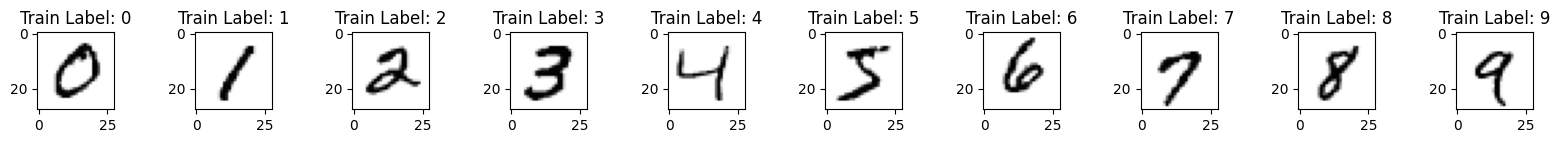

*** MNIST Test ***
np.shape(mnist_x_test) = (10000, 28, 28, 1)
np.shape(mnist_y_test) = (10000,)
Unique labels:
0
1
2
3
4
5
6
7
8
9
Data point visualization:


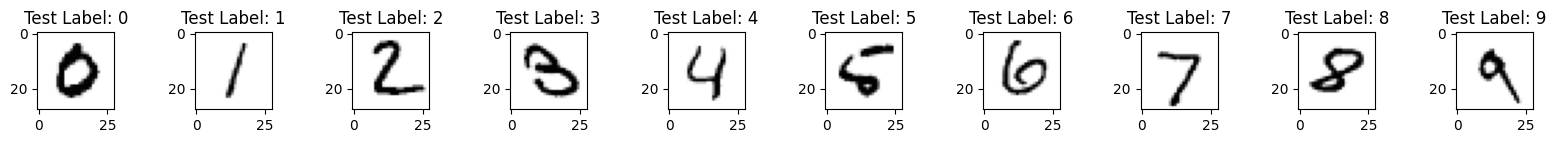

In [4]:
# Load datasets
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()

# Reshape the datasets to have 1 color channel as MNIST contrains greyscale images
mnist_x_train = mnist_x_train.reshape(mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2], 1)
mnist_x_test = mnist_x_test.reshape(mnist_x_test.shape[0], mnist_x_test.shape[1], mnist_x_test.shape[2], 1)

# Normalize values to improve model performance
mnist_x_train = mnist_x_train.astype('float32') / 255
mnist_x_test = mnist_x_test.astype('float32') / 255

# Visualization
# MNIST Train set
## Print unique labels
print("*** MNIST Train ***")
print(f"np.shape(mnist_x_train) = {np.shape(mnist_x_train)}")
print(f"np.shape(mnist_y_train) = {np.shape(mnist_y_train)}")
uniqueArr = np.unique(mnist_y_train)
uniqueArrSize = np.size(uniqueArr)
print("Unique labels:")
for label in uniqueArr:
    print(label) 
    
## Show a single example of each label from the training set
figTrain, axTrain = plt.subplots(1, uniqueArrSize, figsize=(20, 1))
print("Data point visualization:")
for i in range(uniqueArrSize):
    # Use the first example of a specified label
    sample = mnist_x_train[mnist_y_train==i][0]
    axTrain[i].imshow(sample, cmap="Greys")
    axTrain[i].set_title(f"Train Label: {i}")
plt.show()

# MNIST Test set
## Print unique labels
print("*** MNIST Test ***")
print(f"np.shape(mnist_x_test) = {np.shape(mnist_x_test)}")
print(f"np.shape(mnist_y_test) = {np.shape(mnist_y_test)}")
uniqueArr = np.unique(mnist_y_test)
uniqueArrSize = np.size(uniqueArr)
print("Unique labels:")
for label in uniqueArr:
    print(label)
    
## Show a single example of each label from the testing set
print("Data point visualization:")
figTest, axTest = plt.subplots(1, uniqueArrSize, figsize=(20, 1))
for i in range(uniqueArrSize):
    # Use the first example of a specified label
    sample = mnist_x_test[mnist_y_test==i][0]
    axTest[i].imshow(sample, cmap="Greys")
    axTest[i].set_title(f"Test Label: {i}")
plt.show()

Since the labels are ordinal, we want to convert them to categorical(one-hot encoding) labels as the model would have 10 output nodes, each representing the probability of a single class.

In [5]:
# One hot encode labels
mnist_y_train = tf.keras.utils.to_categorical(mnist_y_train)
mnist_y_test = tf.keras.utils.to_categorical(mnist_y_test)

## Setting up the Neural Network
Now with the dataset loaded, we can start to set-up the TensorFlow neural network. In this notebook, we will be using a model consisting of these layers in order:
1. Input Layer
2. Convolution Layer (ReLU)
3. Max Pooling Layer
4. Convolution Layer (ReLU)
5. Max Pooling Layer
6. Flattening Layer
7. Dense Layer
8. Output Layer

![CNN Visualization](images/CNN_Layers.png)<br>
_Note: Ignore the final Conv2D layer. It should not exist there._

### Convolution Layer
In the convolution layer, filters or kernels are applied to the image with the goal to recognizing specific features from the image. We can think of it as the kernel representing the feature that we want to recognize/extract from the original image. By applying the filter to the image (convoluting), the result would be a slightly smaller image that matches the feature represented by the kernel. The image below shows the result of applying the kernel on the original results in a smaller(size) output image that matches more closely to the kernel.<br>
It is also worth noting that we apply ReLU(Rectified Linear Unit) activation function on the output to keep the values positive.<br>
![Convolution Kernel](images/convolution_sample.png)<br><br>
**During the convolution layer, one image becomes a stack of filtered images.**<br>
_Note: Output image is smaller as we do not convolve the cells in the borders as the kernel do not fit. In other words, convolution only takes place on cells that do not fall in the borders._

### Max Pooling Layer
During max pooling, the following happens:
1. Pick a window size, usually 2x2 or 3x3
2. Pick a stride, usually 2
3. Walk the window across the filtered images, shifting the window by stride number of cells each time
4. From each window take the maximum value


![Max Pooling in-depth](images/max_pooling_annotate.png)<br>
Here we can see that the maximum value in the window is $0.55$, as inserted into the max pooled image on the right. It is also worth noting that the window is shifted by $2$ cells(stride) every time.<br><br>
![Max Pooling Sample](images/max_pooling_sample.png)<br>
By taking the maximum value of each window, we end up with a shrunken but similar version of the filtered image.

### Flattening Layer
The flattening layer unrolls the input into a single dimension. The order its is unrolled is dependent on the data format(channels first vs channels last).<br>
E.g. Given $[[[1,2,3], [4,5,6]], [[7,8,9], [10,11,12]]]$ and data_format is channels_last, this will be flatted to $[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]$<br>
This layer serves as an intermediary before the data is passed on to the fully connected (Dense) layers.

### Dense Layer
The dense layer is the standard neural network layer where every input is connected to every node in the next layer, where each input has a weight. The layer acts as a "voting process" where each value gets a vote on what digit the original image should be.

## Implementation
Now with the nitty gritty out of the way, let's implement our CNN.

In [8]:
# Define CNN base
model = models.Sequential()

# Add the layers into the model
# Conv layer parameters:
    ## 32 - Number of output filters
    ## (3,3) - Size of kernel
    ## (28,28,1) - Since this is the first layer, we specify the shape of the input that this layer should take in.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
# Max Pool layer parameters:
    ## (2,2) here refers to the pool size. We ignore stride in example
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
# Flatten multi-dimensional outputs into 1D
model.add(layers.Flatten())
# Fully connected layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Describe the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [9]:
# Configures model for training
# Optimizers are techniques or algorithms used to decrease loss (an error) by tuning various parameters and weights,
# hence minimizing the loss function, providing better accuracy of model faster.  - Gradient Descent, Stochastic GD, RMSProp, etc.
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy', 'mean_squared_error'])

# Fitting the model
model.fit(mnist_x_train, mnist_y_train, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 15s 16ms/step - loss: 0.1714 - accuracy: 0.9478 - mean_squared_error: 0.0078
Epoch 2/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0512 - accuracy: 0.9843 - mean_squared_error: 0.0024
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0354 - accuracy: 0.9894 - mean_squared_error: 0.0017
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0260 - accuracy: 0.9919 - mean_squared_error: 0.0012
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0209 - accuracy: 0.9939 - mean_squared_error: 9.7453e-04


In [10]:
# Evaluate the model
results = model.evaluate(mnist_x_test, mnist_y_test)

print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"MSE: {results[2]}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0343 - accuracy: 0.9883 - mean_squared_error: 0.0017
Loss: 0.034260209649801254
Accuracy: 0.9883000254631042
MSE: 0.0016752576921135187
